# Classificação de Data Streams com Concept Drift

Olá! Neste notebook explicarei como fazemos a classificação de Data Streams com Concept Drift em Python! Mas primeiro, vamos tentar enteder o que são Data Streams, e o que é Concept Drift.

## Data Streams

Quando vamos fazer alguma coisa relacionada a Machine Learning, utilizamos uma base de dados, certo? E essa base de dados geralmente vem em batches, ou seja, em lote. Já podemos separá-la entre treino e teste. Mas quando falamos de Data Streams, esses dados chegam a todo momento. E qual o ponto disso? Em algum momento no tempo, pode acontecer alguma mudança em como esses dados se comportam. É essa mudança de conceito que chamamos de Concept Drift.

## Concept Drift

Temos algumas maneiras de explicar o que é um Concept Drift. Em termos gerais, é quando algo que acontece normalmente no mundo real muda. Por exemplo, tivemos a pandemia há algum tempo, certo? Todos começamos a usar máscaras ao sair da rua. Agora imagine um algoritmo de reconhecimento facial. Será que ele ainda conseguirá reconhecer os rostos de máscara? Se você tem um celular com reconhecimento facial, sabe a resposta.

Não, ele não conseguirá reconhecer bem os rostos. Isso porque ele nunca viu aquele conceito antes. Então podemos simplesmente treinar o modelo sobre os rostos com máscara, certo? Sim, isso poder ser feito, mas agora vamos ver alguns problemas dessa abordagem.

## Memória

Quando falamos de Data Streams, temos que ter em mente que os dados estão chegando a todo momento. Já consegue imaginar o problema? Suponha que sua empresa tenha os dados na nuvem, e você precisa pagar pelo armazenamento. Entendeu agora? Pois é, uma quantidade muito grande de dados pede um armazenamento maior, e no contexto de Data Streams isso pode acabar virando uma bola de neve.

E lembramos que, em algum momento, pode acontecer uma mudança de conceito, as coisas passarão a funcionar de forma diferente na vida real. Assim, se você mantiver dados que não ajudam o seu modelo a fazer as predições, atrapalham, na verdade, faz sentido deixá-los de lado, certo? E esse é um dos pontos que precisamos levar em conta quando trabalhamos com Concept Drift, o de que temos um limite de memória para trabalhar.

# Concept Drift em Python

Temos uma biblioteca para trabalhar nesse cenário em Python, chamada Scikit Multiflow. Ela tem uma API semelhante à do Scikit Learn. A documentação está disponível em https://scikit-multiflow.github.io/. Existem algumas universidades que trabalham para mantê-lo, dentre elas a Universidade de Waikato, de onde saiu o Weka e o MOA (provavelmente o framework mais utilizado em Concept Drift).

Vamos às importações:

In [208]:
# Gera uma base de dados com Concept Drift
from skmultiflow.data import HyperplaneGenerator
# Nos permite utilizar Hoeffding Trees, método amplamente utilizado no cenário do Concept Drift
from skmultiflow.trees import HoeffdingTreeClassifier
# Método de avaliação de Data Streams
from skmultiflow.evaluation import EvaluatePrequential

## Hyperplane Generator

Primeiramente, importamos o HyperplaneGenerator, que gera um problema de predição de classe, muito útil para simular conceitos que mudam com o passar do tempo. Devemos levar em conta que esta é uma base de dados artificial Por que utilizamos bases artificiais? Porque assim temos um controle melhor do que está acontecendo, e também é mais fácil de entender o que é concept drift. Mais à frente neste notebook, veremos um exemplo com uma base real. Mas no momento, para fins didáticos, manteremos essa.

## Hoeffding Tree

Hoeffding Trees é um poderoso algoritmo amplamente utilizado para lidar com Concept Drift, que utiliza como base uma estatística chamada Hoeffding Bound.

## Evaluate Prequential

Este é um método de avaliação de Concept Drift

In [211]:
# Vamos primeiro gerar a nossa base de dados

stream = HyperplaneGenerator()

In [212]:
db = []
for i in range(20000):
    db.append(stream.next_sample())

In [213]:
import pandas as pd
import numpy as np

In [214]:
db[1][0]

array([[0.24348924, 0.37818959, 0.58175734, 0.30874409, 0.59618053,
        0.79537932, 0.53661955, 0.99399229, 0.25651358, 0.90233377]])

In [215]:
test = []
for i in range(20000):
    test.append(np.column_stack((db[i][0], db[i][1])))

In [216]:
test = np.array(test)

In [217]:
test.shape

(20000, 1, 11)

In [218]:
test = test.reshape(-1, 11)

In [219]:
db = pd.DataFrame(test)

In [220]:
from sklearn.tree import DecisionTreeClassifier

In [271]:
dtc = DecisionTreeClassifier()

In [222]:
# Para visualizar os dados gerados
db

,0,1,2,3,4,5,6,7,8,9,10
0,0.781552,0.242269,0.359087,0.068020,0.426051,0.248956,0.926220,0.818448,0.616383,0.070983,0.0
1,0.243489,0.378190,0.581757,0.308744,0.596181,0.795379,0.536620,0.993992,0.256514,0.902334,1.0
2,0.724493,0.571866,0.978167,0.404513,0.607587,0.883714,0.674128,0.449637,0.127372,0.245177,1.0
3,0.293507,0.527014,0.591786,0.774992,0.206198,0.219836,0.004755,0.022370,0.923709,0.941104,0.0
4,0.384258,0.576976,0.084717,0.190672,0.853379,0.428418,0.777678,0.538285,0.292015,0.671804,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.240972,0.998617,0.275062,0.401749,0.195555,0.326846,0.150887,0.331794,0.383514,0.843495,0.0
19996,0.656663,0.793969,0.325932,0.477514,0.108428,0.755349,0.540420,0.917923,0.754223,0.073243,1.0
19997,0.564115,0.729764,0.481941,0.324059,0.964427,0.502455,0.314992,0.186168,0.944932,0.056613,0.0
19998,0.485152,0.373995,0.998761,0.398613,0.661800,0.729817,0.651512,0.994489,0.988845,0.759012,1.0


In [226]:
X = db.drop(10, axis=1)

In [227]:
X

,0,1,2,3,4,5,6,7,8,9
0,0.781552,0.242269,0.359087,0.068020,0.426051,0.248956,0.926220,0.818448,0.616383,0.070983
1,0.243489,0.378190,0.581757,0.308744,0.596181,0.795379,0.536620,0.993992,0.256514,0.902334
2,0.724493,0.571866,0.978167,0.404513,0.607587,0.883714,0.674128,0.449637,0.127372,0.245177
3,0.293507,0.527014,0.591786,0.774992,0.206198,0.219836,0.004755,0.022370,0.923709,0.941104
4,0.384258,0.576976,0.084717,0.190672,0.853379,0.428418,0.777678,0.538285,0.292015,0.671804
...,...,...,...,...,...,...,...,...,...,...
19995,0.240972,0.998617,0.275062,0.401749,0.195555,0.326846,0.150887,0.331794,0.383514,0.843495
19996,0.656663,0.793969,0.325932,0.477514,0.108428,0.755349,0.540420,0.917923,0.754223,0.073243
19997,0.564115,0.729764,0.481941,0.324059,0.964427,0.502455,0.314992,0.186168,0.944932,0.056613
19998,0.485152,0.373995,0.998761,0.398613,0.661800,0.729817,0.651512,0.994489,0.988845,0.759012


In [228]:
y = db[10]

In [229]:
y

0        0.0
1        1.0
2        1.0
3        0.0
4        0.0
        ... 
19995    0.0
19996    1.0
19997    0.0
19998    1.0
19999    1.0
Name: 10, Length: 20000, dtype: float64

In [230]:
from sklearn.model_selection import train_test_split

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [272]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [273]:
from sklearn.metrics import accuracy_score

In [274]:
predictions = dtc.predict(X_test)

In [276]:
accuracy_score(predictions, y_test)

0.7916666666666666

Percebe o que fizemos aqui? Faríamos exatamente isso se fôssemos treinar um model de ML da forma que estamos acostumados. Primeiro separamos a base em treino e teste, então treinamos e fazemos o teste. Mas assim não temos uma boa performance, veja que conseguimos 79%. Isso é porque pegamos instâncias em momentos diferentes no tempo. Vamos tentar pegar instâncias que estão próximas uma da outra no tempo?

In [236]:
X_1 = X[0:50]
y_1 = y[0:50]
X_test_1 = X[50:60]
y_test_1 = y[50:60]

In [237]:
y_test_1

50    1.0
51    0.0
52    1.0
53    0.0
54    1.0
55    0.0
56    1.0
57    1.0
58    1.0
59    0.0
Name: 10, dtype: float64

In [238]:
dtc_1 = DecisionTreeClassifier()

In [239]:
dtc_1.fit(X_1, y_1)

DecisionTreeClassifier()

In [240]:
pred = dtc_1.predict(X_test_1)

In [241]:
accuracy_score(pred, y_test_1)

0.9

Vemos que conseguimos uma acurácia maior! Mas utilizamos poucos dados para fazer o teste, é verdade. Mas talvez tenhamos pego esses dados antes da mudança de conceito, concorda? Vamos tentar pegar mais dados para o teste.

In [242]:
X_test_1 = X[50:70]
y_test_1 = y[50:70]

In [243]:
pred = dtc_1.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.75

In [244]:
X_test_1 = X[50:80]
y_test_1 = y[50:80]

In [245]:
pred = dtc_1.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.6333333333333333

In [246]:
X_test_1 = X[50:90]
y_test_1 = y[50:90]

In [247]:
pred = dtc_1.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.6

In [248]:
X_test_1 = X[50:100]
y_test_1 = y[50:100]

In [249]:
pred = dtc_1.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.66

In [250]:
X_test_1 = X[50:150]
y_test_1 = y[50:150]

pred = dtc_1.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.68

Perceba que, ao avançarmos mais no tempo, nosso modelo começou a diminuir sua acurácia. Claro, utilizamos mais dados para fazer o teste. Vamos tentar fazer melhor

In [257]:
X_2 = X[0:14000]
y_2 = y[0:14000]
X_test_2 = X[14000:20000]
y_test_2 = y[14000:20000]

In [258]:
dtc_2 = DecisionTreeClassifier()

dtc_2.fit(X_2, y_2)

pred = dtc_2.predict(X_test_2)

In [259]:
accuracy_score(pred, y_test_2)

0.7991666666666667

Veja que conseguimos 79% de acurácia ao utilizar 30% dos dados para teste. Vamos ver agora como o algoritmos se saiu nas últimas instâncias com o mesmo modelo.

In [260]:
X_test_3 = X[19500:20000]
y_test_3 = y[19500:20000]

In [261]:
pred = dtc_2.predict(X_test_3)
accuracy_score(pred, y_test_3)

0.764

Nada bom... nosso modelo acertou apenas 76,4% das últimas instâncias que entraram. Mas não tínhamos 90% no início? Por que caiu tanto? 

Porque aconteceu alguma mudança de conceito no meio do caminho. Perceba também que, se utilizarmos toda a base de dados, não conseguimos resultados tão bons quanto poderíamos. Por isso que, ao lidar com Concept Drift, precisamos levar em conta o tempo, ou em que momento as instâncias chegaram.

### Vamos tentar agora com um algoritmo que foi feito para lidar com essas mudanças de conceito.

In [262]:
ht = HoeffdingTreeClassifier()

In [283]:
# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 20000

In [284]:
X_ht = []
y_ht = []

# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    X_ht.append(X)
    y_ht.append(y)
    y_pred = ht.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    ht = ht.partial_fit(X, y)
    n_samples += 1

In [285]:
print('{} samples analyzed.'.format(n_samples))
print('Hoeffding Tree accuracy: {}'.format(correct_cnt / n_samples))

20000 samples analyzed.
Hoeffding Tree accuracy: 0.8906


Veja que aqui também analizamos 2000 amostras da base de dados. Assim, conseguimos uma acurácia de 89,35% para 20000 instâncias geradas. Perceba que, quando utilizamos uma árvore de decisão comum, conseguimos 79% ao separar os dados entre treino e teste.

Vale mencionar também que, para Concept Drift, é utilizada a abordagem test-then-train. O modelo primeiro é feito, e com o passar do tempo ele deve ser atualizado para o conceito mais recente.

Vamos comparar a performance dos dois modelos nos últimos dados, sim?

In [288]:
dct = DecisionTreeClassifier()

In [295]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_ht), np.array(y_ht), test_size=0.33, random_state=42)

In [300]:
X_train = X_train.reshape(-1, 10)

In [302]:
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [304]:
X_test = X_test.reshape(-1, 10)

In [305]:
pred = dct.predict(X_test)

In [306]:
accuracy_score(pred, y_test)

0.803030303030303

Bom, com uma árvore de decisão comum, para a mesma base de dados que utilizamos para a Hoeffding Tree conseguimos 80,3%. Uma diferença considerável, não concorda?

# Base de dados real

In [307]:
db = pd.read_csv('datasets/covtype.csv')

In [308]:
db

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


Não perderemos muito tempo com o pré-processamento desses dados (devo fazer isso depois). O objetivo agora é mostrar como um algoritmo de Concept Drift se comporta no mundo real.

## Forest Covertype Dataset

Essa base de dados que importamos (disponível em https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset) contém os tipos de cobertura de florestas para célular de 30 x 30 metros obtidas do Serviço Florestal do EUA (USFS) Região 2 Recurso de Sistemas e Informação (RIS) de dados.

Ela contém 581.012 instâncias e 54 atributos.

Vamos fazer o que fizemos antes, primeiro dividiremos a base entre treino e teste e treinaremos uma árvore de decisão comum.

In [491]:
X = db.drop('Cover_Type', axis=1)
y = db['Cover_Type']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [316]:
dtc = DecisionTreeClassifier()

In [317]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [318]:
pred = dtc.predict(X_test)

In [319]:
accuracy_score(pred, y_test)

0.9335381309522568

Vemos que conseguimos uma acurácia de 93%. À primeira vista não parece ruim, certo? Mas bem, vamos dar uma olhada mais de perto no que está acontecendo.

In [326]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [342]:
cf_matrix = confusion_matrix(pred, y_test)

<IPython.core.display.Javascript object>


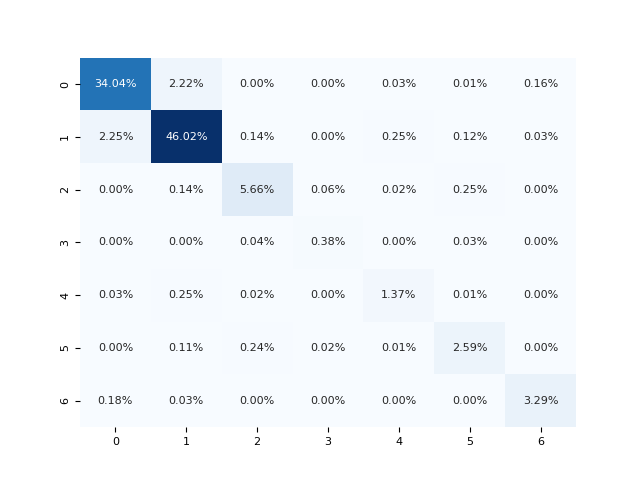

In [345]:
plt.figure()
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues', cbar=False, fmt='.2%')
plt.show()

<IPython.core.display.Javascript object>


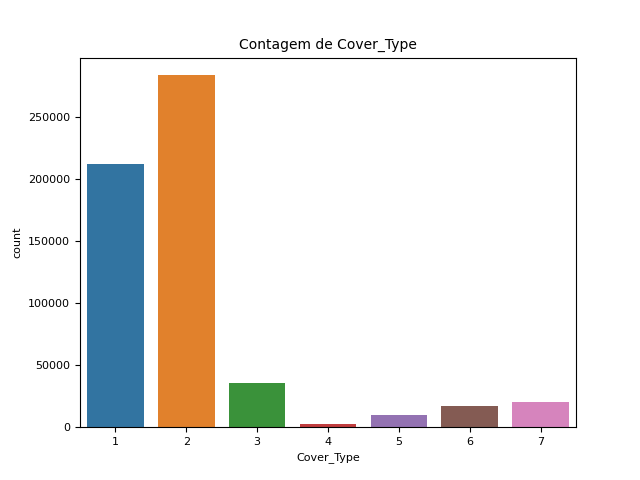

In [352]:
plt.figure()
sns.countplot(x='Cover_Type', data=db)
plt.title("Contagem de Cover_Type")
plt.show()

Vemos que temos dados desbalanceados nessa base de dados. Pela matriz de confusão, nosso modelo parece ter ido bem na classificação, certo? Vamos ver como nossa Hoeffding Tree se sai agora.

In [497]:
from skmultiflow.data import DataStream

In [501]:
stream = DataStream(np.array(X), y=np.array(y))

In [502]:
ht = HoeffdingTreeClassifier()

In [503]:
import progressbar

bar = progressbar.ProgressBar(max_value=len(db))

In [504]:
# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = len(db)

# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = ht.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    ht = ht.partial_fit(X, y)
    n_samples += 1
    bar.update(n_samples)

 99% (580997 of 581012) |############### | Elapsed Time: 0:21:05 ETA:   0:00:00

In [505]:
# Display results
print('{} samples analyzed.'.format(n_samples))
print('Hoeffding Tree accuracy: {}'.format(correct_cnt / n_samples))

581012 samples analyzed.
Hoeffding Tree accuracy: 0.8232738738614693


Olha só, parece que a árvore de decisão teve uma acurácia melhor, não é? Vamos tentar de novo. Faremos a mesma coisa que fizemos no teste anterior: Ver a acurácia nas últimas instâncias.

In [506]:
X = db.drop('Cover_Type', axis=1)
y = db['Cover_Type']

In [518]:
X_test_1 = X[-1000:-1]

In [519]:
y_test_1 = y[-1000:-1]

# Árvore de Decisão

In [520]:
pred = dtc.predict(X_test_1)
accuracy_score(pred, y_test_1)

0.977977977977978

# HT

Fazer com que o modelo seja treinado apenas até antes dos últimos 1000 exemplos para fazer os testes.

In [523]:
correct_cnt = 0
n_samples = 0

for i in range(len(X_test_1)):
    X, y = stream.last_sample()
    y_pred = ht.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    n_samples += 1

In [524]:
print('{} samples analyzed.'.format(n_samples))
print('Hoeffding Tree accuracy: {}'.format(correct_cnt / n_samples))

999 samples analyzed.
Hoeffding Tree accuracy: 1.0
